# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

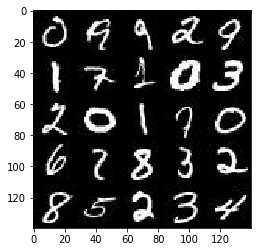

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

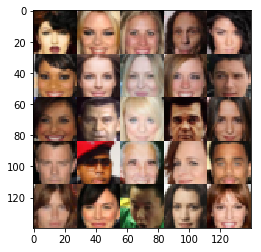

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_images = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    z = tf.placeholder(tf.float32, [None, z_dim])
    learning_rate = tf.placeholder(tf.float32)

    return input_images, z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/carnd/anaconda3/envs/dl/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/carnd/anaconda3/envs/dl/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>\n    app.launch_new_instance()', 'File "/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start\n    ioloop.IOLoop.instance().start()', 'File "/home/carnd/anaconda3/envs/dl/

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        conv1 = tf.maximum(alpha * conv1, conv1)
        
        conv2 = tf.layers.conv2d(conv1, 128, 5, strides=2, padding='same')
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.maximum(alpha * conv2, conv2)
        
        conv3 = tf.layers.conv2d(conv2, 256, 5, strides=2, padding='same')
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = tf.maximum(alpha * conv3, conv3)
        
        flat = tf.reshape(conv3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.1
    
    with tf.variable_scope('generator', reuse=not is_train):
        
        fc1 = tf.layers.dense(z, 7*7*512)
        fc1 = tf.reshape(fc1, (-1, 7, 7, 512))
        fc1 = tf.layers.batch_normalization(fc1, training=is_train)
        fc1 = tf.maximum(alpha * fc1, fc1)
        
        conv1 = tf.layers.conv2d_transpose(fc1, 256, 5, strides=1, padding='same')
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.maximum(alpha * conv1, conv1)
        
        conv2 = tf.layers.conv2d_transpose(conv1, 128, 5, strides=2, padding='same')
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = tf.maximum(alpha * conv2, conv2)
        
        logits = tf.layers.conv2d_transpose(conv2, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)

    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_real)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_training_operation = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_training_operation = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_training_operation, g_training_operation

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    n_samples, width, height, channels = data_shape
    input_real, input_z, learn_rate = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0
    print_steps = 10
    image_steps = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images *= 2
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                if steps % image_steps == 0:
                    n_images = 16
                    show_generator_output(sess, n_images, input_z, channels, data_image_mode)

                if steps % print_steps == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 9.2120... Generator Loss: 0.0002
Epoch 0/2... Discriminator Loss: 2.3470... Generator Loss: 4.2362
Epoch 0/2... Discriminator Loss: 2.9201... Generator Loss: 6.0837
Epoch 0/2... Discriminator Loss: 2.6838... Generator Loss: 2.7639
Epoch 0/2... Discriminator Loss: 1.4283... Generator Loss: 1.6596
Epoch 0/2... Discriminator Loss: 1.5733... Generator Loss: 0.9831
Epoch 0/2... Discriminator Loss: 1.8173... Generator Loss: 1.1931
Epoch 0/2... Discriminator Loss: 1.8126... Generator Loss: 1.1860
Epoch 0/2... Discriminator Loss: 1.7545... Generator Loss: 1.2276


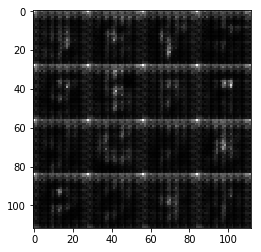

Epoch 0/2... Discriminator Loss: 1.6980... Generator Loss: 0.9294
Epoch 0/2... Discriminator Loss: 1.5906... Generator Loss: 1.3125
Epoch 0/2... Discriminator Loss: 1.5420... Generator Loss: 0.7484
Epoch 0/2... Discriminator Loss: 1.5674... Generator Loss: 0.8815
Epoch 0/2... Discriminator Loss: 1.7033... Generator Loss: 1.0779
Epoch 0/2... Discriminator Loss: 1.4714... Generator Loss: 0.6431
Epoch 0/2... Discriminator Loss: 1.6293... Generator Loss: 0.6742
Epoch 0/2... Discriminator Loss: 1.4619... Generator Loss: 0.8570
Epoch 0/2... Discriminator Loss: 1.4882... Generator Loss: 0.8971
Epoch 0/2... Discriminator Loss: 1.5385... Generator Loss: 1.0274


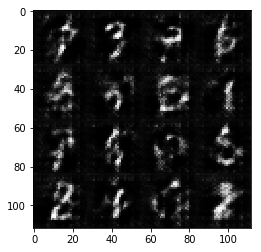

Epoch 0/2... Discriminator Loss: 1.5376... Generator Loss: 0.8866
Epoch 0/2... Discriminator Loss: 1.3979... Generator Loss: 1.0453
Epoch 0/2... Discriminator Loss: 1.5185... Generator Loss: 0.8188
Epoch 0/2... Discriminator Loss: 1.5473... Generator Loss: 0.8520
Epoch 0/2... Discriminator Loss: 1.5078... Generator Loss: 1.1443
Epoch 0/2... Discriminator Loss: 1.3585... Generator Loss: 0.7593
Epoch 0/2... Discriminator Loss: 1.6123... Generator Loss: 0.7859
Epoch 0/2... Discriminator Loss: 1.6542... Generator Loss: 1.1409
Epoch 0/2... Discriminator Loss: 1.5793... Generator Loss: 1.0471
Epoch 0/2... Discriminator Loss: 1.3833... Generator Loss: 0.7480


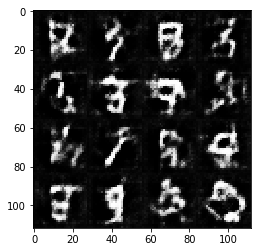

Epoch 0/2... Discriminator Loss: 1.7556... Generator Loss: 0.2370
Epoch 0/2... Discriminator Loss: 1.8595... Generator Loss: 0.2249
Epoch 0/2... Discriminator Loss: 1.4490... Generator Loss: 0.4341
Epoch 0/2... Discriminator Loss: 1.5330... Generator Loss: 0.3616
Epoch 0/2... Discriminator Loss: 1.7336... Generator Loss: 0.2806
Epoch 0/2... Discriminator Loss: 1.6004... Generator Loss: 0.2968
Epoch 0/2... Discriminator Loss: 1.4282... Generator Loss: 0.4313
Epoch 0/2... Discriminator Loss: 1.5965... Generator Loss: 0.3266
Epoch 0/2... Discriminator Loss: 1.5072... Generator Loss: 0.4120
Epoch 0/2... Discriminator Loss: 1.6763... Generator Loss: 0.3020


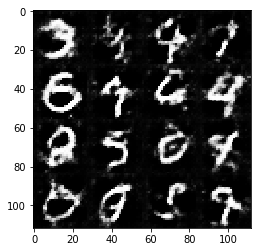

Epoch 0/2... Discriminator Loss: 1.5475... Generator Loss: 0.3356
Epoch 0/2... Discriminator Loss: 1.6309... Generator Loss: 0.3068
Epoch 0/2... Discriminator Loss: 1.6705... Generator Loss: 0.2944
Epoch 0/2... Discriminator Loss: 1.7591... Generator Loss: 0.2742
Epoch 0/2... Discriminator Loss: 1.7031... Generator Loss: 0.2836
Epoch 0/2... Discriminator Loss: 1.5181... Generator Loss: 0.3601
Epoch 0/2... Discriminator Loss: 1.6271... Generator Loss: 0.3149
Epoch 0/2... Discriminator Loss: 1.4855... Generator Loss: 0.3690
Epoch 0/2... Discriminator Loss: 1.5387... Generator Loss: 1.2680
Epoch 0/2... Discriminator Loss: 1.4175... Generator Loss: 0.7180


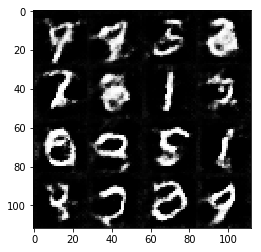

Epoch 0/2... Discriminator Loss: 1.5603... Generator Loss: 0.3806
Epoch 0/2... Discriminator Loss: 1.5185... Generator Loss: 0.3443
Epoch 0/2... Discriminator Loss: 1.5282... Generator Loss: 0.3501
Epoch 0/2... Discriminator Loss: 1.5703... Generator Loss: 0.3534
Epoch 0/2... Discriminator Loss: 1.5358... Generator Loss: 0.3739
Epoch 0/2... Discriminator Loss: 1.3771... Generator Loss: 0.4255
Epoch 0/2... Discriminator Loss: 1.8770... Generator Loss: 0.2093
Epoch 0/2... Discriminator Loss: 1.8826... Generator Loss: 0.2058
Epoch 0/2... Discriminator Loss: 1.4963... Generator Loss: 0.3723
Epoch 0/2... Discriminator Loss: 1.4312... Generator Loss: 0.3717


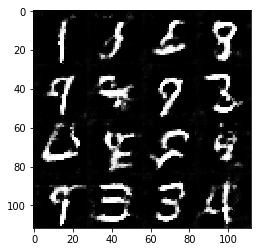

Epoch 0/2... Discriminator Loss: 1.6692... Generator Loss: 0.2772
Epoch 0/2... Discriminator Loss: 1.6210... Generator Loss: 0.3089
Epoch 0/2... Discriminator Loss: 1.7543... Generator Loss: 0.2465
Epoch 0/2... Discriminator Loss: 1.6444... Generator Loss: 0.3141
Epoch 0/2... Discriminator Loss: 1.2246... Generator Loss: 0.7462
Epoch 0/2... Discriminator Loss: 1.3226... Generator Loss: 0.9812
Epoch 0/2... Discriminator Loss: 1.4027... Generator Loss: 1.2168
Epoch 0/2... Discriminator Loss: 1.4076... Generator Loss: 0.9889
Epoch 0/2... Discriminator Loss: 1.1840... Generator Loss: 0.8790
Epoch 0/2... Discriminator Loss: 1.5616... Generator Loss: 1.5553


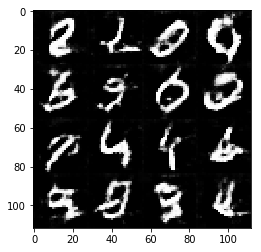

Epoch 0/2... Discriminator Loss: 1.2552... Generator Loss: 0.9347
Epoch 0/2... Discriminator Loss: 1.4766... Generator Loss: 0.3738
Epoch 0/2... Discriminator Loss: 1.5910... Generator Loss: 0.3111
Epoch 0/2... Discriminator Loss: 1.5413... Generator Loss: 0.3649
Epoch 0/2... Discriminator Loss: 1.5790... Generator Loss: 0.3166
Epoch 0/2... Discriminator Loss: 1.3340... Generator Loss: 0.4330
Epoch 0/2... Discriminator Loss: 1.3215... Generator Loss: 1.2425
Epoch 0/2... Discriminator Loss: 1.4966... Generator Loss: 0.8138
Epoch 0/2... Discriminator Loss: 1.1005... Generator Loss: 1.3052
Epoch 0/2... Discriminator Loss: 1.3213... Generator Loss: 1.0010


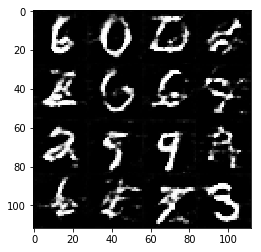

Epoch 0/2... Discriminator Loss: 1.2187... Generator Loss: 1.2489
Epoch 0/2... Discriminator Loss: 1.3049... Generator Loss: 0.6534
Epoch 0/2... Discriminator Loss: 1.2025... Generator Loss: 1.4788
Epoch 0/2... Discriminator Loss: 1.2888... Generator Loss: 0.9680
Epoch 0/2... Discriminator Loss: 1.3386... Generator Loss: 1.1242
Epoch 0/2... Discriminator Loss: 1.2773... Generator Loss: 1.1486
Epoch 0/2... Discriminator Loss: 1.1356... Generator Loss: 0.8050
Epoch 0/2... Discriminator Loss: 1.5101... Generator Loss: 0.3183
Epoch 0/2... Discriminator Loss: 1.4393... Generator Loss: 0.4205
Epoch 0/2... Discriminator Loss: 1.6142... Generator Loss: 0.2958


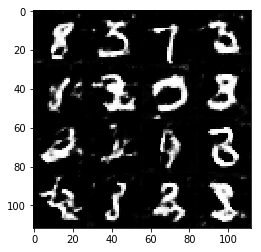

Epoch 0/2... Discriminator Loss: 1.6844... Generator Loss: 0.2743
Epoch 0/2... Discriminator Loss: 1.2743... Generator Loss: 0.5569
Epoch 0/2... Discriminator Loss: 1.6944... Generator Loss: 0.2776
Epoch 0/2... Discriminator Loss: 1.6892... Generator Loss: 0.2630
Epoch 0/2... Discriminator Loss: 1.4271... Generator Loss: 0.3706
Epoch 0/2... Discriminator Loss: 1.2383... Generator Loss: 1.2068
Epoch 0/2... Discriminator Loss: 1.3335... Generator Loss: 1.1113
Epoch 0/2... Discriminator Loss: 1.6614... Generator Loss: 1.6283
Epoch 0/2... Discriminator Loss: 1.1246... Generator Loss: 0.6613
Epoch 0/2... Discriminator Loss: 1.7664... Generator Loss: 0.2355


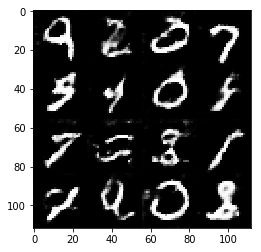

Epoch 0/2... Discriminator Loss: 1.8950... Generator Loss: 0.2406
Epoch 0/2... Discriminator Loss: 1.0154... Generator Loss: 0.7620
Epoch 0/2... Discriminator Loss: 1.2572... Generator Loss: 1.2291
Epoch 0/2... Discriminator Loss: 1.4001... Generator Loss: 1.2374
Epoch 0/2... Discriminator Loss: 1.8755... Generator Loss: 0.2062
Epoch 0/2... Discriminator Loss: 1.4780... Generator Loss: 0.3511
Epoch 0/2... Discriminator Loss: 1.7163... Generator Loss: 0.3017
Epoch 0/2... Discriminator Loss: 1.3934... Generator Loss: 0.3993
Epoch 0/2... Discriminator Loss: 1.4635... Generator Loss: 0.3645
Epoch 0/2... Discriminator Loss: 1.1638... Generator Loss: 0.5318


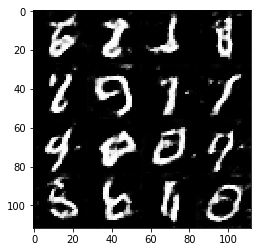

Epoch 0/2... Discriminator Loss: 1.4200... Generator Loss: 1.2170
Epoch 0/2... Discriminator Loss: 1.2608... Generator Loss: 0.7815
Epoch 0/2... Discriminator Loss: 1.2990... Generator Loss: 0.4560
Epoch 0/2... Discriminator Loss: 1.4469... Generator Loss: 0.3709
Epoch 0/2... Discriminator Loss: 1.6225... Generator Loss: 0.2722
Epoch 0/2... Discriminator Loss: 1.5666... Generator Loss: 0.3310
Epoch 0/2... Discriminator Loss: 1.3919... Generator Loss: 0.3791
Epoch 0/2... Discriminator Loss: 1.1914... Generator Loss: 0.5397
Epoch 0/2... Discriminator Loss: 1.5487... Generator Loss: 0.3272
Epoch 0/2... Discriminator Loss: 1.2680... Generator Loss: 0.5071


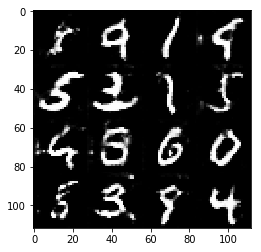

Epoch 0/2... Discriminator Loss: 1.3807... Generator Loss: 1.5964
Epoch 0/2... Discriminator Loss: 1.1228... Generator Loss: 0.8787
Epoch 0/2... Discriminator Loss: 1.1957... Generator Loss: 1.2750
Epoch 0/2... Discriminator Loss: 0.9841... Generator Loss: 1.0744
Epoch 0/2... Discriminator Loss: 0.8375... Generator Loss: 0.9814
Epoch 0/2... Discriminator Loss: 1.4424... Generator Loss: 2.0674
Epoch 0/2... Discriminator Loss: 1.2124... Generator Loss: 1.0419
Epoch 0/2... Discriminator Loss: 1.0704... Generator Loss: 1.0164
Epoch 0/2... Discriminator Loss: 1.0488... Generator Loss: 0.8515
Epoch 0/2... Discriminator Loss: 1.9537... Generator Loss: 0.2102


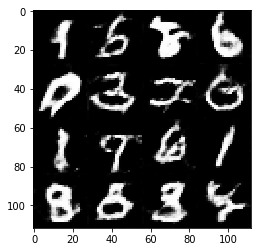

Epoch 0/2... Discriminator Loss: 1.5209... Generator Loss: 1.6709
Epoch 0/2... Discriminator Loss: 1.0828... Generator Loss: 0.7766
Epoch 0/2... Discriminator Loss: 1.5631... Generator Loss: 0.3195
Epoch 0/2... Discriminator Loss: 1.3344... Generator Loss: 0.4391
Epoch 0/2... Discriminator Loss: 1.7009... Generator Loss: 0.2914
Epoch 0/2... Discriminator Loss: 1.3184... Generator Loss: 0.3993
Epoch 0/2... Discriminator Loss: 0.9898... Generator Loss: 1.1845
Epoch 0/2... Discriminator Loss: 0.8794... Generator Loss: 0.9320
Epoch 0/2... Discriminator Loss: 1.8204... Generator Loss: 0.2257
Epoch 0/2... Discriminator Loss: 1.5857... Generator Loss: 0.2976


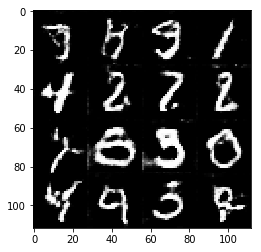

Epoch 0/2... Discriminator Loss: 1.4193... Generator Loss: 0.3734
Epoch 0/2... Discriminator Loss: 1.5245... Generator Loss: 0.3322
Epoch 0/2... Discriminator Loss: 1.3663... Generator Loss: 0.4032
Epoch 0/2... Discriminator Loss: 1.4460... Generator Loss: 0.4176
Epoch 0/2... Discriminator Loss: 1.7514... Generator Loss: 0.2635
Epoch 0/2... Discriminator Loss: 1.2688... Generator Loss: 0.4542
Epoch 0/2... Discriminator Loss: 1.4587... Generator Loss: 0.3633
Epoch 0/2... Discriminator Loss: 1.4110... Generator Loss: 0.3917
Epoch 0/2... Discriminator Loss: 1.1395... Generator Loss: 0.7601
Epoch 0/2... Discriminator Loss: 1.0719... Generator Loss: 0.6225


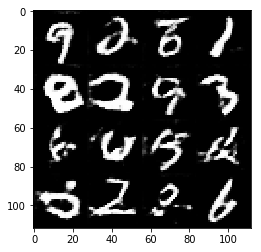

Epoch 0/2... Discriminator Loss: 1.2486... Generator Loss: 0.4083
Epoch 0/2... Discriminator Loss: 1.5858... Generator Loss: 0.3527
Epoch 0/2... Discriminator Loss: 1.0829... Generator Loss: 0.8259
Epoch 0/2... Discriminator Loss: 1.3371... Generator Loss: 0.4234
Epoch 0/2... Discriminator Loss: 1.4188... Generator Loss: 0.3423
Epoch 0/2... Discriminator Loss: 1.1390... Generator Loss: 0.5673
Epoch 0/2... Discriminator Loss: 1.8067... Generator Loss: 0.2520
Epoch 0/2... Discriminator Loss: 0.7230... Generator Loss: 1.0742
Epoch 0/2... Discriminator Loss: 1.2030... Generator Loss: 0.6106
Epoch 0/2... Discriminator Loss: 1.6226... Generator Loss: 0.2935


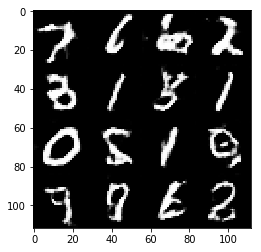

Epoch 0/2... Discriminator Loss: 1.6250... Generator Loss: 0.2713
Epoch 0/2... Discriminator Loss: 1.5732... Generator Loss: 0.2967
Epoch 0/2... Discriminator Loss: 1.5372... Generator Loss: 0.3412
Epoch 0/2... Discriminator Loss: 1.2477... Generator Loss: 0.4708
Epoch 0/2... Discriminator Loss: 1.5303... Generator Loss: 0.3450
Epoch 0/2... Discriminator Loss: 1.4200... Generator Loss: 0.3847
Epoch 0/2... Discriminator Loss: 1.1077... Generator Loss: 0.5433
Epoch 0/2... Discriminator Loss: 1.6353... Generator Loss: 0.2972
Epoch 0/2... Discriminator Loss: 1.2360... Generator Loss: 1.5625
Epoch 0/2... Discriminator Loss: 0.9425... Generator Loss: 1.4933


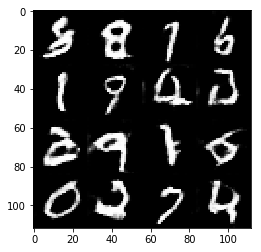

Epoch 0/2... Discriminator Loss: 1.3284... Generator Loss: 1.4509
Epoch 0/2... Discriminator Loss: 0.7455... Generator Loss: 1.1764
Epoch 0/2... Discriminator Loss: 1.2904... Generator Loss: 0.4314
Epoch 0/2... Discriminator Loss: 1.5526... Generator Loss: 0.3851
Epoch 0/2... Discriminator Loss: 0.8058... Generator Loss: 1.0511
Epoch 0/2... Discriminator Loss: 0.8270... Generator Loss: 1.5651
Epoch 0/2... Discriminator Loss: 0.9460... Generator Loss: 0.7010
Epoch 0/2... Discriminator Loss: 1.5825... Generator Loss: 0.3001
Epoch 0/2... Discriminator Loss: 1.3734... Generator Loss: 0.3972
Epoch 0/2... Discriminator Loss: 1.5301... Generator Loss: 2.0264


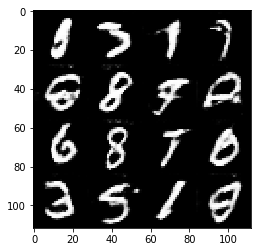

Epoch 0/2... Discriminator Loss: 0.9363... Generator Loss: 1.4019
Epoch 0/2... Discriminator Loss: 1.6146... Generator Loss: 0.3364
Epoch 0/2... Discriminator Loss: 1.2931... Generator Loss: 0.4875
Epoch 0/2... Discriminator Loss: 1.1337... Generator Loss: 1.0925
Epoch 0/2... Discriminator Loss: 0.8053... Generator Loss: 0.8054
Epoch 0/2... Discriminator Loss: 1.4839... Generator Loss: 0.3326
Epoch 0/2... Discriminator Loss: 1.0676... Generator Loss: 1.7749
Epoch 0/2... Discriminator Loss: 0.8239... Generator Loss: 2.1682
Epoch 1/2... Discriminator Loss: 0.9872... Generator Loss: 1.2472
Epoch 1/2... Discriminator Loss: 1.8271... Generator Loss: 0.2349


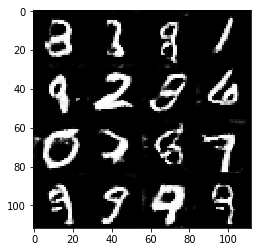

Epoch 1/2... Discriminator Loss: 1.3788... Generator Loss: 0.4152
Epoch 1/2... Discriminator Loss: 1.8236... Generator Loss: 0.2479
Epoch 1/2... Discriminator Loss: 0.7567... Generator Loss: 1.4629
Epoch 1/2... Discriminator Loss: 0.6604... Generator Loss: 1.1210
Epoch 1/2... Discriminator Loss: 0.8418... Generator Loss: 0.8576
Epoch 1/2... Discriminator Loss: 1.5348... Generator Loss: 0.3654
Epoch 1/2... Discriminator Loss: 1.0157... Generator Loss: 2.0494
Epoch 1/2... Discriminator Loss: 0.6655... Generator Loss: 1.6315
Epoch 1/2... Discriminator Loss: 1.1971... Generator Loss: 1.9735
Epoch 1/2... Discriminator Loss: 1.2229... Generator Loss: 2.1942


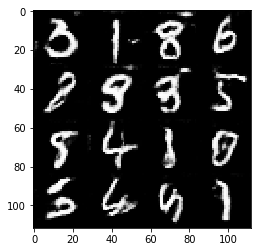

Epoch 1/2... Discriminator Loss: 1.5473... Generator Loss: 0.4284
Epoch 1/2... Discriminator Loss: 0.6444... Generator Loss: 1.0914
Epoch 1/2... Discriminator Loss: 0.8030... Generator Loss: 2.4290
Epoch 1/2... Discriminator Loss: 0.8721... Generator Loss: 1.8484
Epoch 1/2... Discriminator Loss: 1.4518... Generator Loss: 0.3451
Epoch 1/2... Discriminator Loss: 1.6931... Generator Loss: 0.2876
Epoch 1/2... Discriminator Loss: 2.0975... Generator Loss: 0.1820
Epoch 1/2... Discriminator Loss: 0.7622... Generator Loss: 1.2495
Epoch 1/2... Discriminator Loss: 0.8798... Generator Loss: 0.7249
Epoch 1/2... Discriminator Loss: 0.8889... Generator Loss: 0.6916


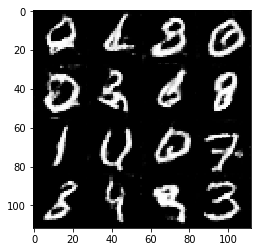

Epoch 1/2... Discriminator Loss: 1.6162... Generator Loss: 0.3030
Epoch 1/2... Discriminator Loss: 1.5666... Generator Loss: 0.3175
Epoch 1/2... Discriminator Loss: 1.3269... Generator Loss: 0.4082
Epoch 1/2... Discriminator Loss: 0.7395... Generator Loss: 0.9052
Epoch 1/2... Discriminator Loss: 1.3093... Generator Loss: 0.3942
Epoch 1/2... Discriminator Loss: 0.9076... Generator Loss: 0.8423
Epoch 1/2... Discriminator Loss: 0.9104... Generator Loss: 0.9563
Epoch 1/2... Discriminator Loss: 0.9188... Generator Loss: 1.6348
Epoch 1/2... Discriminator Loss: 0.9177... Generator Loss: 1.5277
Epoch 1/2... Discriminator Loss: 0.6215... Generator Loss: 1.1709


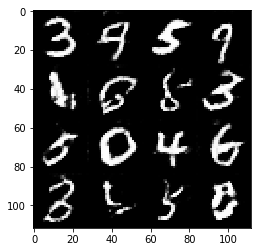

Epoch 1/2... Discriminator Loss: 2.0015... Generator Loss: 0.1878
Epoch 1/2... Discriminator Loss: 0.7216... Generator Loss: 0.9560
Epoch 1/2... Discriminator Loss: 0.7858... Generator Loss: 1.1474
Epoch 1/2... Discriminator Loss: 1.6371... Generator Loss: 0.3022
Epoch 1/2... Discriminator Loss: 2.2003... Generator Loss: 0.1424
Epoch 1/2... Discriminator Loss: 1.5908... Generator Loss: 2.4431
Epoch 1/2... Discriminator Loss: 1.1950... Generator Loss: 0.5917
Epoch 1/2... Discriminator Loss: 2.0444... Generator Loss: 0.1928
Epoch 1/2... Discriminator Loss: 1.5176... Generator Loss: 2.5818
Epoch 1/2... Discriminator Loss: 0.8607... Generator Loss: 1.3985


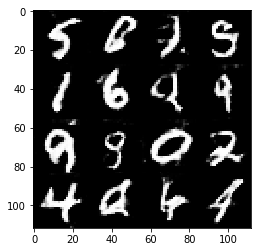

Epoch 1/2... Discriminator Loss: 0.8257... Generator Loss: 2.1911
Epoch 1/2... Discriminator Loss: 1.2087... Generator Loss: 0.4983
Epoch 1/2... Discriminator Loss: 0.6217... Generator Loss: 1.1015
Epoch 1/2... Discriminator Loss: 0.6002... Generator Loss: 1.0082
Epoch 1/2... Discriminator Loss: 2.6869... Generator Loss: 0.1066
Epoch 1/2... Discriminator Loss: 0.9468... Generator Loss: 0.8337
Epoch 1/2... Discriminator Loss: 0.7029... Generator Loss: 2.5071
Epoch 1/2... Discriminator Loss: 0.6746... Generator Loss: 1.2512
Epoch 1/2... Discriminator Loss: 0.8104... Generator Loss: 2.3321
Epoch 1/2... Discriminator Loss: 0.7314... Generator Loss: 1.0384


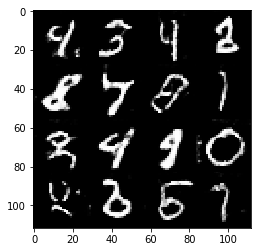

Epoch 1/2... Discriminator Loss: 0.9244... Generator Loss: 2.0014
Epoch 1/2... Discriminator Loss: 1.0725... Generator Loss: 0.6658
Epoch 1/2... Discriminator Loss: 1.8674... Generator Loss: 0.2400
Epoch 1/2... Discriminator Loss: 1.5781... Generator Loss: 0.3205
Epoch 1/2... Discriminator Loss: 1.2779... Generator Loss: 0.4543
Epoch 1/2... Discriminator Loss: 0.8107... Generator Loss: 1.0687
Epoch 1/2... Discriminator Loss: 2.4941... Generator Loss: 3.6796
Epoch 1/2... Discriminator Loss: 1.8997... Generator Loss: 0.2083
Epoch 1/2... Discriminator Loss: 2.1203... Generator Loss: 0.1663
Epoch 1/2... Discriminator Loss: 0.6395... Generator Loss: 1.1629


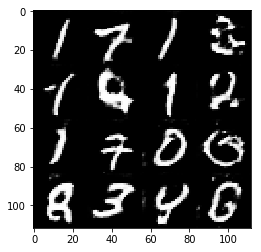

Epoch 1/2... Discriminator Loss: 1.3598... Generator Loss: 2.2731
Epoch 1/2... Discriminator Loss: 0.7125... Generator Loss: 1.6940
Epoch 1/2... Discriminator Loss: 0.6306... Generator Loss: 1.2210
Epoch 1/2... Discriminator Loss: 0.8786... Generator Loss: 1.6986
Epoch 1/2... Discriminator Loss: 1.5711... Generator Loss: 0.2886
Epoch 1/2... Discriminator Loss: 1.2436... Generator Loss: 0.4720
Epoch 1/2... Discriminator Loss: 0.9550... Generator Loss: 0.6679
Epoch 1/2... Discriminator Loss: 1.8843... Generator Loss: 0.2594
Epoch 1/2... Discriminator Loss: 0.9434... Generator Loss: 0.7690
Epoch 1/2... Discriminator Loss: 0.3931... Generator Loss: 1.6644


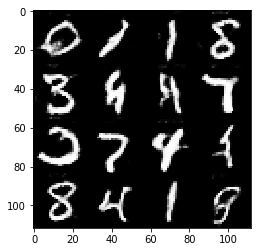

Epoch 1/2... Discriminator Loss: 2.0262... Generator Loss: 0.2161
Epoch 1/2... Discriminator Loss: 0.8292... Generator Loss: 1.5210
Epoch 1/2... Discriminator Loss: 0.7021... Generator Loss: 1.3757
Epoch 1/2... Discriminator Loss: 0.7891... Generator Loss: 1.0837
Epoch 1/2... Discriminator Loss: 1.7004... Generator Loss: 0.3152
Epoch 1/2... Discriminator Loss: 0.6919... Generator Loss: 1.8564
Epoch 1/2... Discriminator Loss: 1.3712... Generator Loss: 0.3995
Epoch 1/2... Discriminator Loss: 0.9451... Generator Loss: 1.2581
Epoch 1/2... Discriminator Loss: 0.9997... Generator Loss: 2.2739
Epoch 1/2... Discriminator Loss: 0.9005... Generator Loss: 1.0376


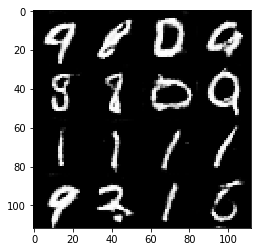

Epoch 1/2... Discriminator Loss: 1.2013... Generator Loss: 0.4760
Epoch 1/2... Discriminator Loss: 0.7885... Generator Loss: 1.7783
Epoch 1/2... Discriminator Loss: 0.4387... Generator Loss: 1.6354
Epoch 1/2... Discriminator Loss: 1.6391... Generator Loss: 2.7310
Epoch 1/2... Discriminator Loss: 0.4814... Generator Loss: 1.4020
Epoch 1/2... Discriminator Loss: 0.3431... Generator Loss: 1.8154
Epoch 1/2... Discriminator Loss: 0.5102... Generator Loss: 1.2327
Epoch 1/2... Discriminator Loss: 0.4046... Generator Loss: 1.6525
Epoch 1/2... Discriminator Loss: 1.3294... Generator Loss: 1.9965
Epoch 1/2... Discriminator Loss: 1.0694... Generator Loss: 0.6637


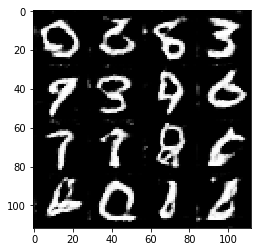

Epoch 1/2... Discriminator Loss: 1.1910... Generator Loss: 0.5297
Epoch 1/2... Discriminator Loss: 0.6150... Generator Loss: 0.9923
Epoch 1/2... Discriminator Loss: 0.9748... Generator Loss: 0.7242
Epoch 1/2... Discriminator Loss: 0.6450... Generator Loss: 1.1225
Epoch 1/2... Discriminator Loss: 0.8098... Generator Loss: 2.2710
Epoch 1/2... Discriminator Loss: 0.7694... Generator Loss: 1.2733
Epoch 1/2... Discriminator Loss: 1.3120... Generator Loss: 0.4322
Epoch 1/2... Discriminator Loss: 0.6722... Generator Loss: 1.1351
Epoch 1/2... Discriminator Loss: 1.0915... Generator Loss: 1.1996
Epoch 1/2... Discriminator Loss: 1.3609... Generator Loss: 0.4143


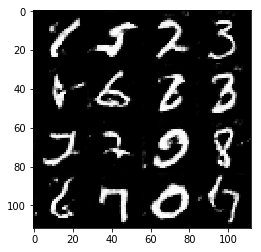

Epoch 1/2... Discriminator Loss: 1.2825... Generator Loss: 0.4315
Epoch 1/2... Discriminator Loss: 1.5823... Generator Loss: 0.3214
Epoch 1/2... Discriminator Loss: 0.7957... Generator Loss: 1.8345
Epoch 1/2... Discriminator Loss: 1.4413... Generator Loss: 0.4086
Epoch 1/2... Discriminator Loss: 0.7042... Generator Loss: 0.9296
Epoch 1/2... Discriminator Loss: 1.6144... Generator Loss: 0.4061
Epoch 1/2... Discriminator Loss: 0.4322... Generator Loss: 2.3686
Epoch 1/2... Discriminator Loss: 1.7934... Generator Loss: 0.2661
Epoch 1/2... Discriminator Loss: 1.6695... Generator Loss: 0.2618
Epoch 1/2... Discriminator Loss: 0.8130... Generator Loss: 0.9741


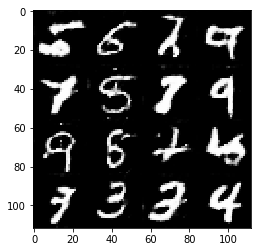

Epoch 1/2... Discriminator Loss: 0.6510... Generator Loss: 1.0557
Epoch 1/2... Discriminator Loss: 2.5144... Generator Loss: 0.1288
Epoch 1/2... Discriminator Loss: 1.9581... Generator Loss: 0.2721
Epoch 1/2... Discriminator Loss: 0.6627... Generator Loss: 3.1464
Epoch 1/2... Discriminator Loss: 0.4534... Generator Loss: 1.3544
Epoch 1/2... Discriminator Loss: 0.4621... Generator Loss: 1.3400
Epoch 1/2... Discriminator Loss: 0.3482... Generator Loss: 1.5889
Epoch 1/2... Discriminator Loss: 1.6799... Generator Loss: 2.9840
Epoch 1/2... Discriminator Loss: 1.0732... Generator Loss: 2.2701
Epoch 1/2... Discriminator Loss: 1.4956... Generator Loss: 0.3117


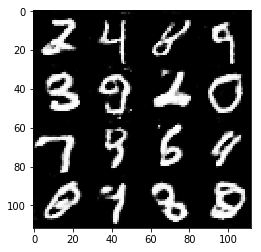

Epoch 1/2... Discriminator Loss: 1.6204... Generator Loss: 0.3648
Epoch 1/2... Discriminator Loss: 0.5380... Generator Loss: 1.4540
Epoch 1/2... Discriminator Loss: 0.3367... Generator Loss: 1.8114
Epoch 1/2... Discriminator Loss: 0.3431... Generator Loss: 2.0542
Epoch 1/2... Discriminator Loss: 0.9742... Generator Loss: 2.6972
Epoch 1/2... Discriminator Loss: 0.9820... Generator Loss: 0.6358
Epoch 1/2... Discriminator Loss: 0.6399... Generator Loss: 1.0075
Epoch 1/2... Discriminator Loss: 0.3602... Generator Loss: 1.8756
Epoch 1/2... Discriminator Loss: 0.4446... Generator Loss: 2.3214
Epoch 1/2... Discriminator Loss: 0.3082... Generator Loss: 1.7853


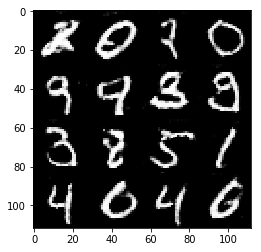

Epoch 1/2... Discriminator Loss: 0.6602... Generator Loss: 1.1303
Epoch 1/2... Discriminator Loss: 0.9131... Generator Loss: 0.7528
Epoch 1/2... Discriminator Loss: 0.4608... Generator Loss: 1.3483
Epoch 1/2... Discriminator Loss: 1.1455... Generator Loss: 0.5973
Epoch 1/2... Discriminator Loss: 1.4180... Generator Loss: 0.5154
Epoch 1/2... Discriminator Loss: 2.3834... Generator Loss: 0.1562
Epoch 1/2... Discriminator Loss: 0.4512... Generator Loss: 2.3510
Epoch 1/2... Discriminator Loss: 0.5910... Generator Loss: 2.2792
Epoch 1/2... Discriminator Loss: 0.6764... Generator Loss: 1.8793
Epoch 1/2... Discriminator Loss: 1.5368... Generator Loss: 2.2914


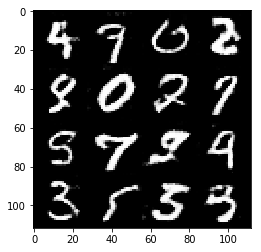

Epoch 1/2... Discriminator Loss: 0.7558... Generator Loss: 1.9264
Epoch 1/2... Discriminator Loss: 0.7328... Generator Loss: 1.0372
Epoch 1/2... Discriminator Loss: 1.2637... Generator Loss: 0.6976
Epoch 1/2... Discriminator Loss: 0.6420... Generator Loss: 1.2753
Epoch 1/2... Discriminator Loss: 0.3772... Generator Loss: 1.6435
Epoch 1/2... Discriminator Loss: 0.4553... Generator Loss: 2.1223
Epoch 1/2... Discriminator Loss: 1.3643... Generator Loss: 0.4581
Epoch 1/2... Discriminator Loss: 1.5728... Generator Loss: 0.3254
Epoch 1/2... Discriminator Loss: 0.5559... Generator Loss: 1.3833
Epoch 1/2... Discriminator Loss: 0.9652... Generator Loss: 0.7209


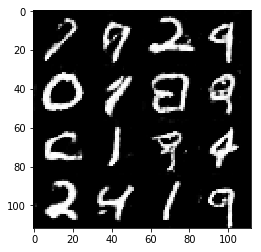

Epoch 1/2... Discriminator Loss: 0.4163... Generator Loss: 1.3175
Epoch 1/2... Discriminator Loss: 0.4395... Generator Loss: 1.4833
Epoch 1/2... Discriminator Loss: 0.3828... Generator Loss: 1.7169
Epoch 1/2... Discriminator Loss: 1.7030... Generator Loss: 4.6434
Epoch 1/2... Discriminator Loss: 0.4518... Generator Loss: 1.5397
Epoch 1/2... Discriminator Loss: 0.4856... Generator Loss: 2.2996
Epoch 1/2... Discriminator Loss: 3.3771... Generator Loss: 5.8869
Epoch 1/2... Discriminator Loss: 0.9844... Generator Loss: 1.3860
Epoch 1/2... Discriminator Loss: 1.9996... Generator Loss: 3.6602
Epoch 1/2... Discriminator Loss: 0.4615... Generator Loss: 1.7124


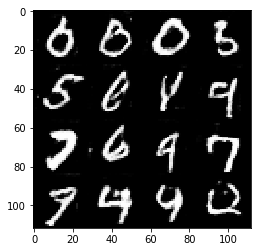

Epoch 1/2... Discriminator Loss: 0.6231... Generator Loss: 2.3626
Epoch 1/2... Discriminator Loss: 0.9363... Generator Loss: 0.7758
Epoch 1/2... Discriminator Loss: 0.4686... Generator Loss: 1.4053
Epoch 1/2... Discriminator Loss: 1.5467... Generator Loss: 3.7492
Epoch 1/2... Discriminator Loss: 0.9818... Generator Loss: 0.8280
Epoch 1/2... Discriminator Loss: 0.6120... Generator Loss: 1.1383
Epoch 1/2... Discriminator Loss: 0.6539... Generator Loss: 1.2664
Epoch 1/2... Discriminator Loss: 0.8096... Generator Loss: 0.7975
Epoch 1/2... Discriminator Loss: 1.6421... Generator Loss: 0.3233
Epoch 1/2... Discriminator Loss: 1.3895... Generator Loss: 0.4604


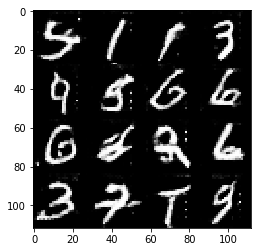

Epoch 1/2... Discriminator Loss: 1.9570... Generator Loss: 0.2505
Epoch 1/2... Discriminator Loss: 0.4972... Generator Loss: 1.5567
Epoch 1/2... Discriminator Loss: 1.7772... Generator Loss: 0.2797
Epoch 1/2... Discriminator Loss: 1.2215... Generator Loss: 0.5233
Epoch 1/2... Discriminator Loss: 0.8814... Generator Loss: 0.8192
Epoch 1/2... Discriminator Loss: 0.3090... Generator Loss: 2.3629
Epoch 1/2... Discriminator Loss: 0.3542... Generator Loss: 1.6365
Epoch 1/2... Discriminator Loss: 0.4604... Generator Loss: 1.3362
Epoch 1/2... Discriminator Loss: 1.2697... Generator Loss: 0.6883
Epoch 1/2... Discriminator Loss: 1.6778... Generator Loss: 0.2996


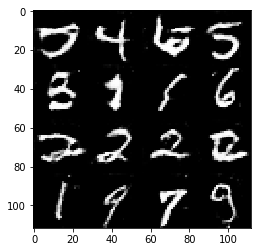

Epoch 1/2... Discriminator Loss: 0.5381... Generator Loss: 1.3121
Epoch 1/2... Discriminator Loss: 0.4621... Generator Loss: 2.3892
Epoch 1/2... Discriminator Loss: 0.4523... Generator Loss: 2.9453
Epoch 1/2... Discriminator Loss: 0.4385... Generator Loss: 1.5094
Epoch 1/2... Discriminator Loss: 2.4878... Generator Loss: 0.1527
Epoch 1/2... Discriminator Loss: 0.8786... Generator Loss: 0.8177


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 2.5925... Generator Loss: 6.6281
Epoch 0/1... Discriminator Loss: 2.2233... Generator Loss: 1.8647
Epoch 0/1... Discriminator Loss: 1.7119... Generator Loss: 0.8389
Epoch 0/1... Discriminator Loss: 1.6734... Generator Loss: 0.3845
Epoch 0/1... Discriminator Loss: 1.6303... Generator Loss: 0.4335
Epoch 0/1... Discriminator Loss: 1.7997... Generator Loss: 0.3138
Epoch 0/1... Discriminator Loss: 1.7367... Generator Loss: 0.4323
Epoch 0/1... Discriminator Loss: 1.7007... Generator Loss: 0.6837
Epoch 0/1... Discriminator Loss: 1.5429... Generator Loss: 0.6263


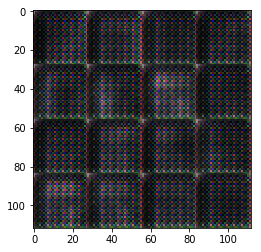

Epoch 0/1... Discriminator Loss: 1.6261... Generator Loss: 0.8961
Epoch 0/1... Discriminator Loss: 1.6286... Generator Loss: 1.0406
Epoch 0/1... Discriminator Loss: 1.5423... Generator Loss: 0.7847
Epoch 0/1... Discriminator Loss: 1.5089... Generator Loss: 0.5321
Epoch 0/1... Discriminator Loss: 1.6816... Generator Loss: 0.3557
Epoch 0/1... Discriminator Loss: 1.4664... Generator Loss: 0.4961
Epoch 0/1... Discriminator Loss: 1.5050... Generator Loss: 0.5121
Epoch 0/1... Discriminator Loss: 1.4455... Generator Loss: 0.5534
Epoch 0/1... Discriminator Loss: 1.4857... Generator Loss: 0.6209
Epoch 0/1... Discriminator Loss: 1.5036... Generator Loss: 0.6058


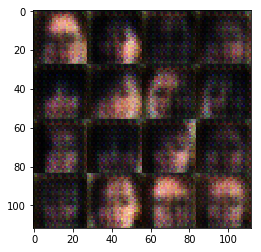

Epoch 0/1... Discriminator Loss: 1.4564... Generator Loss: 0.5229
Epoch 0/1... Discriminator Loss: 1.4278... Generator Loss: 0.5299
Epoch 0/1... Discriminator Loss: 1.5708... Generator Loss: 0.4413
Epoch 0/1... Discriminator Loss: 1.4408... Generator Loss: 0.6747
Epoch 0/1... Discriminator Loss: 1.4327... Generator Loss: 0.7006
Epoch 0/1... Discriminator Loss: 1.4749... Generator Loss: 0.5468
Epoch 0/1... Discriminator Loss: 1.4359... Generator Loss: 0.5334
Epoch 0/1... Discriminator Loss: 1.5385... Generator Loss: 0.4534
Epoch 0/1... Discriminator Loss: 1.5285... Generator Loss: 0.8306
Epoch 0/1... Discriminator Loss: 1.4627... Generator Loss: 0.7076


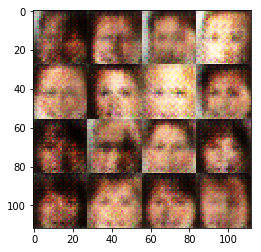

Epoch 0/1... Discriminator Loss: 1.4499... Generator Loss: 0.7049
Epoch 0/1... Discriminator Loss: 1.4545... Generator Loss: 0.8629
Epoch 0/1... Discriminator Loss: 1.4565... Generator Loss: 0.7815
Epoch 0/1... Discriminator Loss: 1.4374... Generator Loss: 0.7623
Epoch 0/1... Discriminator Loss: 1.5196... Generator Loss: 0.8962
Epoch 0/1... Discriminator Loss: 1.4710... Generator Loss: 0.9390
Epoch 0/1... Discriminator Loss: 1.3964... Generator Loss: 0.8792
Epoch 0/1... Discriminator Loss: 1.5920... Generator Loss: 0.9746
Epoch 0/1... Discriminator Loss: 1.4998... Generator Loss: 1.1977
Epoch 0/1... Discriminator Loss: 1.4739... Generator Loss: 0.8972


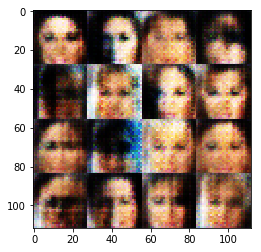

Epoch 0/1... Discriminator Loss: 1.5159... Generator Loss: 0.4363
Epoch 0/1... Discriminator Loss: 1.3481... Generator Loss: 0.5088
Epoch 0/1... Discriminator Loss: 1.1852... Generator Loss: 0.5836
Epoch 0/1... Discriminator Loss: 1.4666... Generator Loss: 0.8873
Epoch 0/1... Discriminator Loss: 1.3774... Generator Loss: 0.6788
Epoch 0/1... Discriminator Loss: 1.4871... Generator Loss: 0.6742
Epoch 0/1... Discriminator Loss: 1.5956... Generator Loss: 0.7213
Epoch 0/1... Discriminator Loss: 1.4769... Generator Loss: 0.6523
Epoch 0/1... Discriminator Loss: 1.4186... Generator Loss: 0.6768
Epoch 0/1... Discriminator Loss: 1.4917... Generator Loss: 0.8018


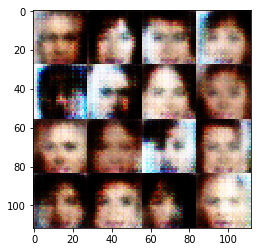

Epoch 0/1... Discriminator Loss: 1.6006... Generator Loss: 0.3440
Epoch 0/1... Discriminator Loss: 1.5117... Generator Loss: 0.3697
Epoch 0/1... Discriminator Loss: 1.5192... Generator Loss: 0.4061
Epoch 0/1... Discriminator Loss: 1.5113... Generator Loss: 0.6560
Epoch 0/1... Discriminator Loss: 1.7918... Generator Loss: 1.4364
Epoch 0/1... Discriminator Loss: 2.1484... Generator Loss: 1.5966
Epoch 0/1... Discriminator Loss: 1.4533... Generator Loss: 0.6383
Epoch 0/1... Discriminator Loss: 1.4343... Generator Loss: 0.7822
Epoch 0/1... Discriminator Loss: 1.2979... Generator Loss: 0.7263
Epoch 0/1... Discriminator Loss: 1.4112... Generator Loss: 0.4596


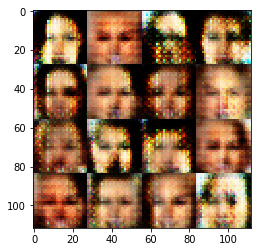

Epoch 0/1... Discriminator Loss: 1.6064... Generator Loss: 0.4746
Epoch 0/1... Discriminator Loss: 1.3767... Generator Loss: 0.4144
Epoch 0/1... Discriminator Loss: 0.6992... Generator Loss: 1.4329
Epoch 0/1... Discriminator Loss: 1.4915... Generator Loss: 1.0648
Epoch 0/1... Discriminator Loss: 1.4018... Generator Loss: 1.0537
Epoch 0/1... Discriminator Loss: 1.4915... Generator Loss: 0.6744
Epoch 0/1... Discriminator Loss: 1.2189... Generator Loss: 0.8111
Epoch 0/1... Discriminator Loss: 1.5633... Generator Loss: 0.6223
Epoch 0/1... Discriminator Loss: 1.4980... Generator Loss: 0.6639
Epoch 0/1... Discriminator Loss: 1.3393... Generator Loss: 0.6741


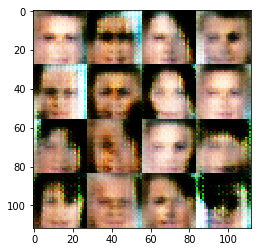

Epoch 0/1... Discriminator Loss: 1.4969... Generator Loss: 1.0471
Epoch 0/1... Discriminator Loss: 1.3981... Generator Loss: 0.6306
Epoch 0/1... Discriminator Loss: 1.3457... Generator Loss: 0.5701
Epoch 0/1... Discriminator Loss: 1.3747... Generator Loss: 0.7050
Epoch 0/1... Discriminator Loss: 1.4350... Generator Loss: 0.6614
Epoch 0/1... Discriminator Loss: 1.4913... Generator Loss: 0.4561
Epoch 0/1... Discriminator Loss: 1.4228... Generator Loss: 0.4777
Epoch 0/1... Discriminator Loss: 1.3944... Generator Loss: 1.1740
Epoch 0/1... Discriminator Loss: 2.2852... Generator Loss: 0.1803
Epoch 0/1... Discriminator Loss: 1.4516... Generator Loss: 0.8771


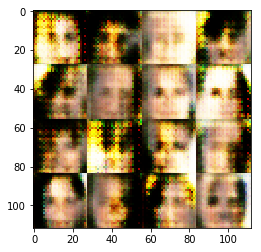

Epoch 0/1... Discriminator Loss: 1.3037... Generator Loss: 0.6810
Epoch 0/1... Discriminator Loss: 1.2956... Generator Loss: 0.9195
Epoch 0/1... Discriminator Loss: 1.7039... Generator Loss: 0.2426
Epoch 0/1... Discriminator Loss: 1.4018... Generator Loss: 0.9988
Epoch 0/1... Discriminator Loss: 1.5200... Generator Loss: 0.3921
Epoch 0/1... Discriminator Loss: 1.4962... Generator Loss: 0.3589
Epoch 0/1... Discriminator Loss: 4.0572... Generator Loss: 2.2812
Epoch 0/1... Discriminator Loss: 1.3888... Generator Loss: 0.5123
Epoch 0/1... Discriminator Loss: 1.1919... Generator Loss: 0.5509
Epoch 0/1... Discriminator Loss: 1.3145... Generator Loss: 0.7280


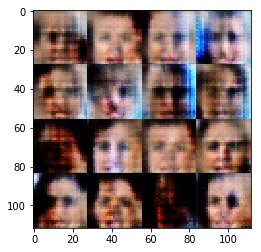

Epoch 0/1... Discriminator Loss: 1.9185... Generator Loss: 1.4717
Epoch 0/1... Discriminator Loss: 1.2674... Generator Loss: 0.9758
Epoch 0/1... Discriminator Loss: 1.2952... Generator Loss: 0.5512
Epoch 0/1... Discriminator Loss: 1.2800... Generator Loss: 0.7020
Epoch 0/1... Discriminator Loss: 1.3847... Generator Loss: 0.9133
Epoch 0/1... Discriminator Loss: 2.3184... Generator Loss: 0.1287
Epoch 0/1... Discriminator Loss: 1.4371... Generator Loss: 0.6576
Epoch 0/1... Discriminator Loss: 1.3186... Generator Loss: 0.7613
Epoch 0/1... Discriminator Loss: 1.4433... Generator Loss: 0.6947
Epoch 0/1... Discriminator Loss: 1.4361... Generator Loss: 0.7542


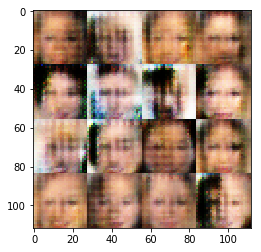

Epoch 0/1... Discriminator Loss: 1.3186... Generator Loss: 0.7217
Epoch 0/1... Discriminator Loss: 1.3360... Generator Loss: 0.6504
Epoch 0/1... Discriminator Loss: 1.4100... Generator Loss: 0.7546
Epoch 0/1... Discriminator Loss: 1.4481... Generator Loss: 0.4073
Epoch 0/1... Discriminator Loss: 1.3214... Generator Loss: 0.5042
Epoch 0/1... Discriminator Loss: 1.4786... Generator Loss: 0.7574
Epoch 0/1... Discriminator Loss: 1.3065... Generator Loss: 0.8408
Epoch 0/1... Discriminator Loss: 1.4221... Generator Loss: 0.8749
Epoch 0/1... Discriminator Loss: 1.2923... Generator Loss: 0.7722
Epoch 0/1... Discriminator Loss: 1.4228... Generator Loss: 0.4339


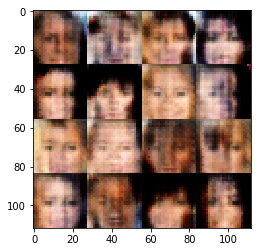

Epoch 0/1... Discriminator Loss: 1.6654... Generator Loss: 1.3046
Epoch 0/1... Discriminator Loss: 1.6040... Generator Loss: 0.9042
Epoch 0/1... Discriminator Loss: 1.3902... Generator Loss: 0.6712
Epoch 0/1... Discriminator Loss: 1.3975... Generator Loss: 0.8358
Epoch 0/1... Discriminator Loss: 1.3281... Generator Loss: 0.7812
Epoch 0/1... Discriminator Loss: 1.4284... Generator Loss: 0.5702
Epoch 0/1... Discriminator Loss: 1.3093... Generator Loss: 0.9099
Epoch 0/1... Discriminator Loss: 1.4803... Generator Loss: 0.4830
Epoch 0/1... Discriminator Loss: 1.3610... Generator Loss: 0.7226
Epoch 0/1... Discriminator Loss: 1.3679... Generator Loss: 0.4569


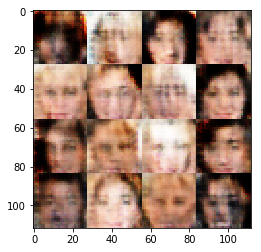

Epoch 0/1... Discriminator Loss: 1.3058... Generator Loss: 0.9422
Epoch 0/1... Discriminator Loss: 1.5331... Generator Loss: 0.8912
Epoch 0/1... Discriminator Loss: 1.4125... Generator Loss: 0.6843
Epoch 0/1... Discriminator Loss: 1.3054... Generator Loss: 0.7595
Epoch 0/1... Discriminator Loss: 1.4338... Generator Loss: 0.5230
Epoch 0/1... Discriminator Loss: 1.3120... Generator Loss: 0.5843
Epoch 0/1... Discriminator Loss: 1.3287... Generator Loss: 0.9022
Epoch 0/1... Discriminator Loss: 1.4590... Generator Loss: 0.4095
Epoch 0/1... Discriminator Loss: 1.2640... Generator Loss: 0.8963
Epoch 0/1... Discriminator Loss: 1.3575... Generator Loss: 0.6652


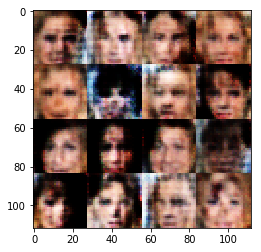

Epoch 0/1... Discriminator Loss: 1.3382... Generator Loss: 0.6444
Epoch 0/1... Discriminator Loss: 1.3748... Generator Loss: 0.8432
Epoch 0/1... Discriminator Loss: 1.3027... Generator Loss: 0.7573
Epoch 0/1... Discriminator Loss: 1.3915... Generator Loss: 0.6263
Epoch 0/1... Discriminator Loss: 1.6918... Generator Loss: 1.2698
Epoch 0/1... Discriminator Loss: 1.4137... Generator Loss: 0.7226
Epoch 0/1... Discriminator Loss: 1.3991... Generator Loss: 0.5860
Epoch 0/1... Discriminator Loss: 1.4418... Generator Loss: 0.6272
Epoch 0/1... Discriminator Loss: 1.4413... Generator Loss: 0.9857
Epoch 0/1... Discriminator Loss: 1.3500... Generator Loss: 0.5239


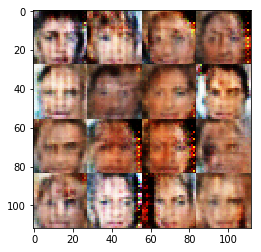

Epoch 0/1... Discriminator Loss: 1.4118... Generator Loss: 0.8555
Epoch 0/1... Discriminator Loss: 1.4342... Generator Loss: 0.8510
Epoch 0/1... Discriminator Loss: 1.4122... Generator Loss: 0.7381
Epoch 0/1... Discriminator Loss: 1.3761... Generator Loss: 0.6284
Epoch 0/1... Discriminator Loss: 1.3708... Generator Loss: 0.7316
Epoch 0/1... Discriminator Loss: 1.3544... Generator Loss: 0.6572
Epoch 0/1... Discriminator Loss: 1.4387... Generator Loss: 0.6364
Epoch 0/1... Discriminator Loss: 1.1792... Generator Loss: 0.5449
Epoch 0/1... Discriminator Loss: 1.4710... Generator Loss: 0.7393
Epoch 0/1... Discriminator Loss: 1.4054... Generator Loss: 0.6703


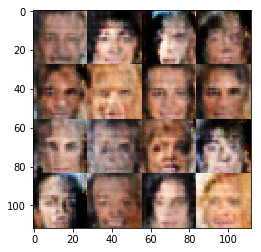

Epoch 0/1... Discriminator Loss: 1.3928... Generator Loss: 0.5449
Epoch 0/1... Discriminator Loss: 1.3241... Generator Loss: 0.7208
Epoch 0/1... Discriminator Loss: 1.3301... Generator Loss: 0.9498
Epoch 0/1... Discriminator Loss: 1.2164... Generator Loss: 0.9362
Epoch 0/1... Discriminator Loss: 1.3672... Generator Loss: 0.7466
Epoch 0/1... Discriminator Loss: 1.3868... Generator Loss: 0.6084
Epoch 0/1... Discriminator Loss: 1.3900... Generator Loss: 0.5230
Epoch 0/1... Discriminator Loss: 1.2685... Generator Loss: 0.7358
Epoch 0/1... Discriminator Loss: 1.4703... Generator Loss: 0.4508
Epoch 0/1... Discriminator Loss: 1.3793... Generator Loss: 0.6872


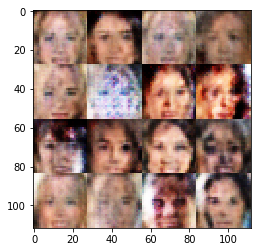

Epoch 0/1... Discriminator Loss: 1.3601... Generator Loss: 0.7553
Epoch 0/1... Discriminator Loss: 1.3903... Generator Loss: 0.6371
Epoch 0/1... Discriminator Loss: 1.4149... Generator Loss: 0.5852
Epoch 0/1... Discriminator Loss: 1.4292... Generator Loss: 0.6948
Epoch 0/1... Discriminator Loss: 1.4166... Generator Loss: 0.8428
Epoch 0/1... Discriminator Loss: 1.4059... Generator Loss: 0.5371
Epoch 0/1... Discriminator Loss: 1.4925... Generator Loss: 0.4821
Epoch 0/1... Discriminator Loss: 1.3798... Generator Loss: 0.7710
Epoch 0/1... Discriminator Loss: 1.3715... Generator Loss: 0.6498
Epoch 0/1... Discriminator Loss: 1.3454... Generator Loss: 0.8581


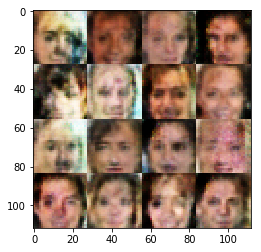

Epoch 0/1... Discriminator Loss: 1.3697... Generator Loss: 0.5848
Epoch 0/1... Discriminator Loss: 1.7680... Generator Loss: 0.2631
Epoch 0/1... Discriminator Loss: 1.4686... Generator Loss: 0.7851
Epoch 0/1... Discriminator Loss: 1.4036... Generator Loss: 0.7431
Epoch 0/1... Discriminator Loss: 1.3964... Generator Loss: 0.7924
Epoch 0/1... Discriminator Loss: 1.3986... Generator Loss: 0.6546
Epoch 0/1... Discriminator Loss: 1.3603... Generator Loss: 0.6274
Epoch 0/1... Discriminator Loss: 1.4574... Generator Loss: 0.6988
Epoch 0/1... Discriminator Loss: 1.4218... Generator Loss: 0.5924
Epoch 0/1... Discriminator Loss: 1.4110... Generator Loss: 0.4144


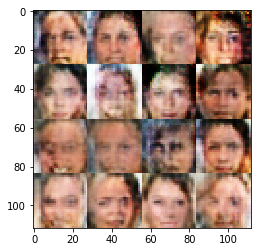

Epoch 0/1... Discriminator Loss: 1.4739... Generator Loss: 0.5069
Epoch 0/1... Discriminator Loss: 1.3999... Generator Loss: 0.6581
Epoch 0/1... Discriminator Loss: 1.3833... Generator Loss: 0.7982
Epoch 0/1... Discriminator Loss: 1.4938... Generator Loss: 0.6719
Epoch 0/1... Discriminator Loss: 1.3975... Generator Loss: 0.6910
Epoch 0/1... Discriminator Loss: 1.3909... Generator Loss: 0.6091
Epoch 0/1... Discriminator Loss: 1.5902... Generator Loss: 1.1050
Epoch 0/1... Discriminator Loss: 1.4234... Generator Loss: 0.6296
Epoch 0/1... Discriminator Loss: 1.3468... Generator Loss: 0.6454
Epoch 0/1... Discriminator Loss: 1.4133... Generator Loss: 0.6814


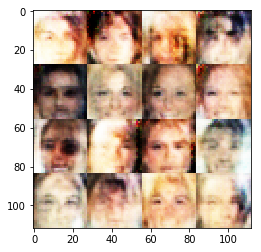

Epoch 0/1... Discriminator Loss: 1.4017... Generator Loss: 0.7357
Epoch 0/1... Discriminator Loss: 1.4111... Generator Loss: 0.6739
Epoch 0/1... Discriminator Loss: 1.4692... Generator Loss: 0.6451
Epoch 0/1... Discriminator Loss: 1.4154... Generator Loss: 0.7154
Epoch 0/1... Discriminator Loss: 1.2872... Generator Loss: 0.6267
Epoch 0/1... Discriminator Loss: 1.3809... Generator Loss: 0.5775
Epoch 0/1... Discriminator Loss: 1.3110... Generator Loss: 0.7337
Epoch 0/1... Discriminator Loss: 1.4038... Generator Loss: 0.6133
Epoch 0/1... Discriminator Loss: 1.4201... Generator Loss: 0.6459
Epoch 0/1... Discriminator Loss: 1.5141... Generator Loss: 0.6237


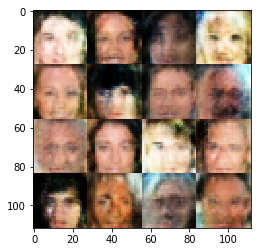

Epoch 0/1... Discriminator Loss: 1.3082... Generator Loss: 0.7096
Epoch 0/1... Discriminator Loss: 1.3663... Generator Loss: 0.6637
Epoch 0/1... Discriminator Loss: 1.5009... Generator Loss: 0.7432
Epoch 0/1... Discriminator Loss: 1.3653... Generator Loss: 0.6841
Epoch 0/1... Discriminator Loss: 1.4135... Generator Loss: 0.7126
Epoch 0/1... Discriminator Loss: 1.3512... Generator Loss: 0.6887
Epoch 0/1... Discriminator Loss: 1.3814... Generator Loss: 0.5976
Epoch 0/1... Discriminator Loss: 1.4593... Generator Loss: 0.6652
Epoch 0/1... Discriminator Loss: 1.3711... Generator Loss: 0.6820
Epoch 0/1... Discriminator Loss: 1.4099... Generator Loss: 0.6904


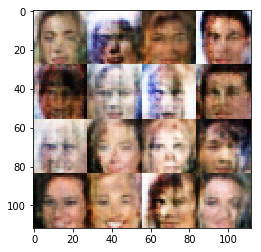

Epoch 0/1... Discriminator Loss: 1.3583... Generator Loss: 0.7094
Epoch 0/1... Discriminator Loss: 1.4197... Generator Loss: 0.6978
Epoch 0/1... Discriminator Loss: 1.3853... Generator Loss: 0.7023
Epoch 0/1... Discriminator Loss: 1.4039... Generator Loss: 0.6052
Epoch 0/1... Discriminator Loss: 1.3717... Generator Loss: 0.7010
Epoch 0/1... Discriminator Loss: 1.4195... Generator Loss: 0.7256
Epoch 0/1... Discriminator Loss: 1.3588... Generator Loss: 0.7074
Epoch 0/1... Discriminator Loss: 1.3732... Generator Loss: 0.8436
Epoch 0/1... Discriminator Loss: 1.3196... Generator Loss: 0.6415
Epoch 0/1... Discriminator Loss: 1.4099... Generator Loss: 0.6472


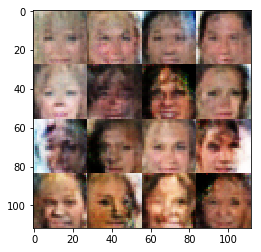

Epoch 0/1... Discriminator Loss: 1.2867... Generator Loss: 0.8348
Epoch 0/1... Discriminator Loss: 1.3889... Generator Loss: 0.7170
Epoch 0/1... Discriminator Loss: 1.3732... Generator Loss: 0.7160
Epoch 0/1... Discriminator Loss: 1.3949... Generator Loss: 0.6056
Epoch 0/1... Discriminator Loss: 1.4011... Generator Loss: 0.5943
Epoch 0/1... Discriminator Loss: 1.3997... Generator Loss: 0.6449
Epoch 0/1... Discriminator Loss: 1.4183... Generator Loss: 0.6553
Epoch 0/1... Discriminator Loss: 1.4071... Generator Loss: 0.5589
Epoch 0/1... Discriminator Loss: 1.4192... Generator Loss: 0.5936
Epoch 0/1... Discriminator Loss: 1.4238... Generator Loss: 0.7830


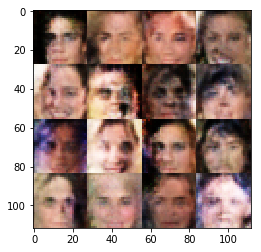

Epoch 0/1... Discriminator Loss: 1.3856... Generator Loss: 0.6828
Epoch 0/1... Discriminator Loss: 1.3912... Generator Loss: 0.6090
Epoch 0/1... Discriminator Loss: 1.3613... Generator Loss: 0.7537
Epoch 0/1... Discriminator Loss: 1.3677... Generator Loss: 0.8073
Epoch 0/1... Discriminator Loss: 1.3813... Generator Loss: 0.6091
Epoch 0/1... Discriminator Loss: 1.4393... Generator Loss: 0.6451
Epoch 0/1... Discriminator Loss: 1.4129... Generator Loss: 0.6579
Epoch 0/1... Discriminator Loss: 1.3744... Generator Loss: 0.4863
Epoch 0/1... Discriminator Loss: 1.3817... Generator Loss: 0.6823
Epoch 0/1... Discriminator Loss: 1.4361... Generator Loss: 0.7774


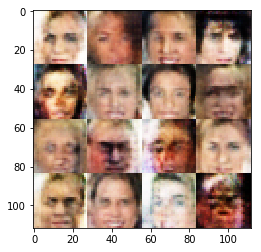

Epoch 0/1... Discriminator Loss: 1.4010... Generator Loss: 0.6886
Epoch 0/1... Discriminator Loss: 1.4522... Generator Loss: 0.7500
Epoch 0/1... Discriminator Loss: 1.3922... Generator Loss: 0.6886
Epoch 0/1... Discriminator Loss: 1.4335... Generator Loss: 0.5011
Epoch 0/1... Discriminator Loss: 1.3692... Generator Loss: 0.7190
Epoch 0/1... Discriminator Loss: 1.3650... Generator Loss: 0.6791
Epoch 0/1... Discriminator Loss: 1.3660... Generator Loss: 0.6141
Epoch 0/1... Discriminator Loss: 1.3841... Generator Loss: 0.6788
Epoch 0/1... Discriminator Loss: 1.3967... Generator Loss: 0.7166
Epoch 0/1... Discriminator Loss: 1.3761... Generator Loss: 0.6990


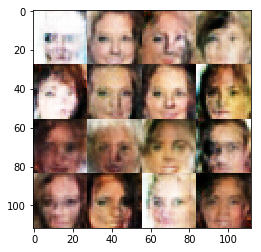

Epoch 0/1... Discriminator Loss: 1.3511... Generator Loss: 0.6520
Epoch 0/1... Discriminator Loss: 1.4115... Generator Loss: 0.7481
Epoch 0/1... Discriminator Loss: 1.3755... Generator Loss: 0.7787
Epoch 0/1... Discriminator Loss: 1.3531... Generator Loss: 0.8051
Epoch 0/1... Discriminator Loss: 1.4229... Generator Loss: 0.8239
Epoch 0/1... Discriminator Loss: 1.4321... Generator Loss: 0.6932
Epoch 0/1... Discriminator Loss: 1.3665... Generator Loss: 0.7367
Epoch 0/1... Discriminator Loss: 1.3696... Generator Loss: 0.7204
Epoch 0/1... Discriminator Loss: 1.4067... Generator Loss: 0.5280
Epoch 0/1... Discriminator Loss: 1.4212... Generator Loss: 0.6679


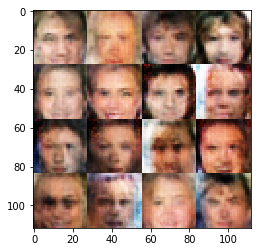

Epoch 0/1... Discriminator Loss: 1.3671... Generator Loss: 0.6419
Epoch 0/1... Discriminator Loss: 1.3913... Generator Loss: 0.6347
Epoch 0/1... Discriminator Loss: 1.3645... Generator Loss: 0.7127
Epoch 0/1... Discriminator Loss: 1.3629... Generator Loss: 0.5841
Epoch 0/1... Discriminator Loss: 1.3973... Generator Loss: 0.6544
Epoch 0/1... Discriminator Loss: 1.3730... Generator Loss: 0.6109
Epoch 0/1... Discriminator Loss: 1.4422... Generator Loss: 0.7092
Epoch 0/1... Discriminator Loss: 1.4898... Generator Loss: 0.6841
Epoch 0/1... Discriminator Loss: 1.3749... Generator Loss: 0.7546
Epoch 0/1... Discriminator Loss: 1.3985... Generator Loss: 0.6368


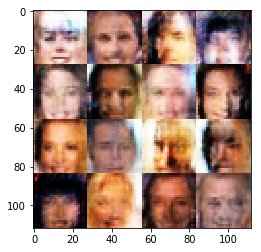

Epoch 0/1... Discriminator Loss: 1.4274... Generator Loss: 0.6712
Epoch 0/1... Discriminator Loss: 1.4377... Generator Loss: 0.6439
Epoch 0/1... Discriminator Loss: 1.4208... Generator Loss: 0.7051
Epoch 0/1... Discriminator Loss: 1.3899... Generator Loss: 0.6792
Epoch 0/1... Discriminator Loss: 1.4199... Generator Loss: 0.7157
Epoch 0/1... Discriminator Loss: 1.3706... Generator Loss: 0.6453
Epoch 0/1... Discriminator Loss: 1.4153... Generator Loss: 0.7534
Epoch 0/1... Discriminator Loss: 1.3910... Generator Loss: 0.7505
Epoch 0/1... Discriminator Loss: 1.3646... Generator Loss: 0.7169
Epoch 0/1... Discriminator Loss: 1.3495... Generator Loss: 0.6459


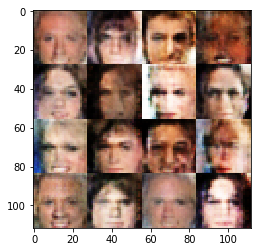

Epoch 0/1... Discriminator Loss: 1.4364... Generator Loss: 0.5828
Epoch 0/1... Discriminator Loss: 1.4077... Generator Loss: 0.6391
Epoch 0/1... Discriminator Loss: 1.4186... Generator Loss: 0.6926
Epoch 0/1... Discriminator Loss: 1.3496... Generator Loss: 0.6780
Epoch 0/1... Discriminator Loss: 1.3817... Generator Loss: 0.7284
Epoch 0/1... Discriminator Loss: 1.3939... Generator Loss: 0.6142
Epoch 0/1... Discriminator Loss: 1.3754... Generator Loss: 0.7102
Epoch 0/1... Discriminator Loss: 1.3976... Generator Loss: 0.7104
Epoch 0/1... Discriminator Loss: 1.3030... Generator Loss: 0.9274
Epoch 0/1... Discriminator Loss: 1.4440... Generator Loss: 0.8058


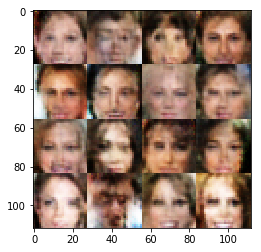

Epoch 0/1... Discriminator Loss: 1.3729... Generator Loss: 0.6125
Epoch 0/1... Discriminator Loss: 1.4065... Generator Loss: 0.6721
Epoch 0/1... Discriminator Loss: 1.3758... Generator Loss: 0.7134
Epoch 0/1... Discriminator Loss: 1.3600... Generator Loss: 0.7331
Epoch 0/1... Discriminator Loss: 1.3740... Generator Loss: 0.7348
Epoch 0/1... Discriminator Loss: 1.3966... Generator Loss: 0.6612
Epoch 0/1... Discriminator Loss: 1.3830... Generator Loss: 0.6849
Epoch 0/1... Discriminator Loss: 1.4235... Generator Loss: 0.8330
Epoch 0/1... Discriminator Loss: 1.3815... Generator Loss: 0.6246
Epoch 0/1... Discriminator Loss: 1.3986... Generator Loss: 0.6588


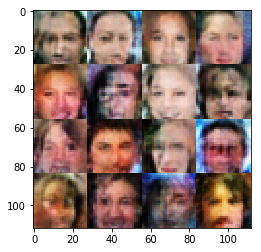

Epoch 0/1... Discriminator Loss: 1.3887... Generator Loss: 0.6718
Epoch 0/1... Discriminator Loss: 1.3518... Generator Loss: 0.6359
Epoch 0/1... Discriminator Loss: 1.3449... Generator Loss: 0.7942
Epoch 0/1... Discriminator Loss: 1.3652... Generator Loss: 0.6409
Epoch 0/1... Discriminator Loss: 1.3997... Generator Loss: 0.6811
Epoch 0/1... Discriminator Loss: 1.3758... Generator Loss: 0.6494
Epoch 0/1... Discriminator Loss: 1.3557... Generator Loss: 0.6835
Epoch 0/1... Discriminator Loss: 1.3857... Generator Loss: 0.7116
Epoch 0/1... Discriminator Loss: 1.3411... Generator Loss: 0.6785
Epoch 0/1... Discriminator Loss: 1.3609... Generator Loss: 0.7065


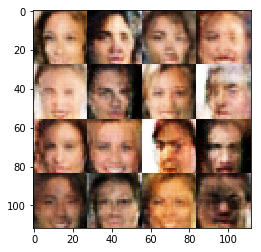

Epoch 0/1... Discriminator Loss: 1.4096... Generator Loss: 0.5884
Epoch 0/1... Discriminator Loss: 1.3641... Generator Loss: 0.6695
Epoch 0/1... Discriminator Loss: 1.3604... Generator Loss: 0.6918
Epoch 0/1... Discriminator Loss: 1.4038... Generator Loss: 0.6361
Epoch 0/1... Discriminator Loss: 1.3903... Generator Loss: 0.7409
Epoch 0/1... Discriminator Loss: 1.3923... Generator Loss: 0.6357
Epoch 0/1... Discriminator Loss: 1.3998... Generator Loss: 0.6895


In [17]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.